In [1]:
# Instalando conda (mamba)
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:16
🔁 Restarting kernel...


In [2]:
# Instalando pacotes necessários
!mamba install -c conda-forge cartopy siphon metpy imgaug
!apt-get -qq install libproj-dev libgeos-dev
!pip uninstall shapely -y
!pip install shapely --no-binary shapely
!pip install pyyaml==5.4.1


Looking for: ['cartopy', 'siphon', 'metpy', 'imgaug']

[+] 0.0s
[+] 0.1s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.2s
conda-forge/linux-64   1%
conda-forge/noarch     1%[+] 0.3s
conda-forge/linux-64   7%
conda-forge/noarch    14%[+] 0.4s
conda-forge/linux-64  12%
conda-forge/noarch    33%[+] 0.5s
conda-forge/linux-64  16%
conda-forge/noarch    44%[+] 0.6s
conda-forge/linux-64  21%
conda-forge/noarch    55%[+] 0.7s
conda-forge/linux-64  25%
conda-forge/noarch    66%[+] 0.8s
conda-forge/linux-64  30%
conda-forge/noarch    66%[+] 0.9s
conda-forge/linux-64  35%
conda-forge/noarch    77%[+] 1.0s
conda-forge/linux-64  39%
conda-forge/noarch    88%conda-forge/noarch                                
[+] 1.1s
conda-forge/linux-64  44%[+] 1.2s
conda-forge/linux-64  53%[+] 1.3s
conda-forge/linux-64  58%[+] 1.4s
conda-forge/linux-64  63%[+] 1.5s
conda-forge/linux-64  77%[+] 1.6s
conda-forge/linux-64  81%[+] 1.7s
conda-forge/linux-64  86%[+] 1.8s
conda-forge/linux-64  96%conda-forge/

In [1]:
# A whole bunch of imports
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import patheffects
import matplotlib.pyplot as plt
from netCDF4 import num2date
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter
from siphon.catalog import TDSCatalog
import xarray as xr
from datetime import datetime
import numpy as np
import numpy.ma as ma
from metpy.io import GiniFile
from metpy.plots.ctables import registry
from metpy.units import units
import metpy.calc as mpcalc

In [2]:
dt = datetime(2024, 6, 5, 12)

# Assemble our URL to the THREDDS Data Server catalog,
# and access our desired dataset within via NCSS
#base_url = 'https://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_onedeg_ana/GFS_Global_onedeg_ana_'
base_url = 'https://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg_ana/GFS_Global_0p25deg_ana_'
cat = TDSCatalog(f'{base_url}{dt:%Y%m%d}_{dt:%H}00.grib2/catalog.xml')
ncss = cat.datasets[0].subset()

# Setando
nivel = 250
lat_sul = -70
lat_norte = 30
lon_leste = 360
lon_oeste = 230
lon_l = lon_leste - 360
lon_o = lon_oeste - 360

# level wind components data
query_wind = ncss.query()
query_wind.variables('u-component_of_wind_isobaric',
                     'v-component_of_wind_isobaric').add_lonlat().accept('netcdf')
query_wind.vertical_level(nivel * 100)
query_wind.lonlat_box(north=lat_norte, south=lat_sul, east=lon_leste, west=lon_oeste)
data_wind = ncss.get_data(query_wind)

# Z nivel
query_hght = ncss.query()
query_hght.variables('Geopotential_height_isobaric').add_lonlat().accept('netcdf')
query_hght.vertical_level(nivel * 100)
query_hght.lonlat_box(north=lat_norte, south=lat_sul, east=lon_leste, west=lon_oeste)
data_hght = ncss.get_data(query_hght)


In [3]:
# Tem que fazer esta alteração para conseguir plotar o vento
lon =  data_hght.variables['longitude'][:]
for i in range(len(lon)):
    if lon[i]>180:
        lon[i] = lon[i]-360

In [4]:
# Grab variables and smooth, use MetPy Units module for conversion
uwnd_nivel = data_wind.variables['u-component_of_wind_isobaric'][:].squeeze()* units('m/s')
vwnd_nivel = data_wind.variables['v-component_of_wind_isobaric'][:].squeeze()* units('m/s')
hght = data_hght.variables['Geopotential_height_isobaric'][:].squeeze()

U_nivel = units('m/s') * ndimage.gaussian_filter(uwnd_nivel, sigma=1, order=0)
V_nivel = units('m/s') * ndimage.gaussian_filter(vwnd_nivel, sigma=1, order=0)
Z = units.meter * ndimage.gaussian_filter(hght, sigma=1, order=0)

#lon = data_hght.variables['lon'][:]
lat = data_hght.variables['latitude'][:]
time = data_hght.variables[data_hght.variables['Geopotential_height_isobaric'].dimensions[0]]
vtime = num2date(time[:], time.units)

In [ ]:
#print(Z.shape)

(301, 520)


In [5]:
# Set up some constants based on our projection, including the Coriolis parameter and
# grid spacing, converting lon/lat spacing to Cartesian
#f = mpcalc.coriolis_parameter(np.deg2rad(lat)).to('1/s')
dx, dy = mpcalc.lat_lon_grid_deltas(lon, lat)
latrad = np.deg2rad(lat)
#print(latrad)
# lev hPa divergence
div_nivel = mpcalc.divergence(U_nivel,V_nivel,dx=dx, dy=dy)
div_nivel = gaussian_filter(div_nivel, 1)
#Quero somente os valores positivos da divergencia
mask_div = ma.masked_less_equal(div_nivel, 0).mask
div_nivel[mask_div] = np.nan

In [6]:
# In MetPy 0.5, geostrophic_wind() assumes the order of the dimensions is (X, Y),
# so we need to transpose from the input data, which are ordered lat (y), lon (x).
# Once we get the components,transpose again so they match our original data.
geo_wind_u, geo_wind_v = mpcalc.geostrophic_wind(Z, dx = dx, dy = dy, latitude = latrad[:, None])
geo_wind_u = geo_wind_u*units('m/s')
geo_wind_v = geo_wind_v*units('m/s')

# Calculate ageostrophic wind components
ageo_wind_u = (uwnd_nivel - geo_wind_u)*units('m/s')
ageo_wind_v = (vwnd_nivel - geo_wind_v)*units('m/s')

ageo_wind_u = units.Quantity(ageo_wind_u, "m/s")
ageo_wind_v = units.Quantity(ageo_wind_v, "m/s")

# Use MetPy to calculate the wind speed for colorfill plot, change units to knots from m/s
speed_ageo = mpcalc.wind_speed(ageo_wind_u, ageo_wind_v)


/usr/local/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


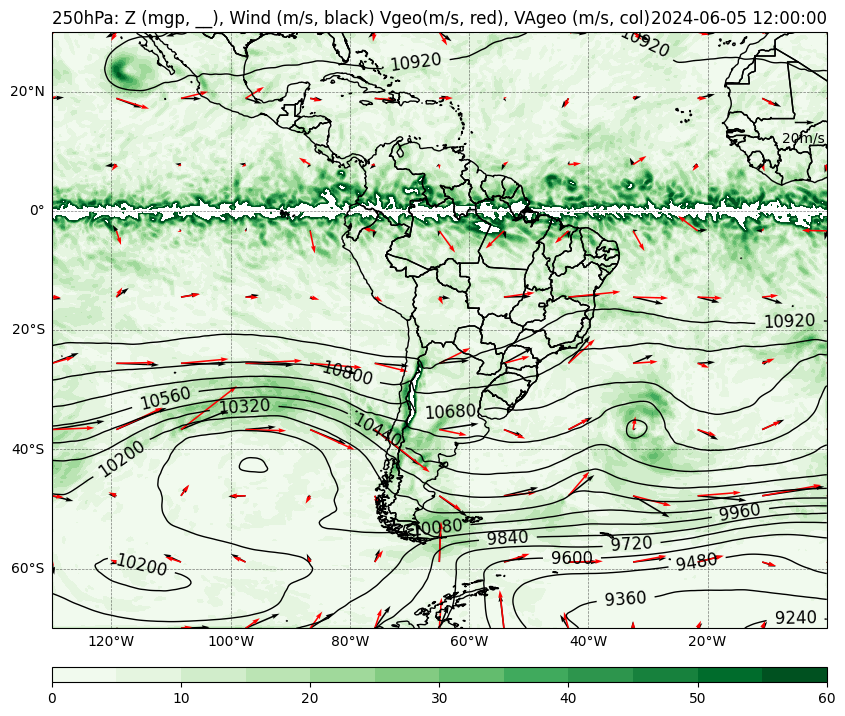

In [7]:
# Create the figure VGEO X VREAL (com VAGEO)
datacrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=datacrs)

# Add mapping information
# Add state boundaries to plot
states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lakes',scale='50m', facecolor='none')
ax.add_feature(states_provinces, edgecolor='black', linewidth=1)
# Add country borders to plot
country_borders = cfeature.NaturalEarthFeature(category='cultural',
                                               name='admin_0_countries',
                                               scale='50m', facecolor='none')
ax.add_feature(country_borders, edgecolor='black', linewidth=1)
ax.set_extent([lon_o, lon_l, lat_sul, lat_norte], ccrs.PlateCarree())

# ageo speed
clevageo = np.arange(0, 61, 5)
ageo = ax.contourf(lon, lat, speed_ageo, clevageo, cmap='Greens', transform=datacrs)
plt.colorbar(ageo, orientation='horizontal', pad=0.05, aspect=50, extendrect=True)

# Plot Z
#250 hPa
clevz = np.arange(9000., 11000., 120)
#500 hPa
#clevz = np.arange(4320., 6500., 60)
#850 hPa
#clevz = np.arange(0, 8000, 30)
ax.set_extent([lon_o, lon_l, lat_sul, lat_norte], ccrs.PlateCarree())
cs = ax.contour(lon, lat,Z, clevz, colors='black', linewidths=1.0,linestyles='solid',transform=ccrs.PlateCarree())
ax.clabel(cs, fontsize=12, colors='black', inline=1, inline_spacing=8,
          fmt='%i', rightside_up=True, use_clabeltext=True)


uv = ax.quiver(lon, lat, U_nivel, V_nivel, color='black',regrid_shape=10,
          width=0.002, scale = 800, transform=ccrs.PlateCarree())
#Draw the wind field, and after the arrow shaft, you have to explain the relationship between the length of the shaft and the wind speed
#Calling quiver can generate reference arrow + label.
ax.quiverkey(uv,                     #Incoming quiver handle
             X=0.97, Y = 0.85,       #Determine the location of label, all limited to [0,1]
             U = 20,                    #Reference arrow length means the wind speed is 5m/s.
             angle = 0,            #Reference arrow placement angle. The default is 0, which means horizontal placement
             label='20m/s',        #Arrow's supplement: label's content +
             labelpos='S',          #label is in which direction of the reference arrow; S means south
             color = 'black',labelcolor = 'black', #Arrow color + label color
             )

uvgeo = ax.quiver(lon, lat, geo_wind_u, geo_wind_v, color='red',regrid_shape=10,
          width=0.002, scale = 800, transform=ccrs.PlateCarree())
ax.set_title(f'{nivel}hPa: Z (mgp, __), Wind (m/s, black) Vgeo(m/s, red), VAgeo (m/s, col)', loc='left')
ax.set_title('{}'.format(vtime[0]), loc='right')

# Adding grid lines
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl.top_labels = False
gl.left_labels = True
gl.right_labels = False
gl.xlines = True

# Salva o grafico no disco
#plt.savefig("jato_z_250.png", dpi=600, bbox_inches="tight")

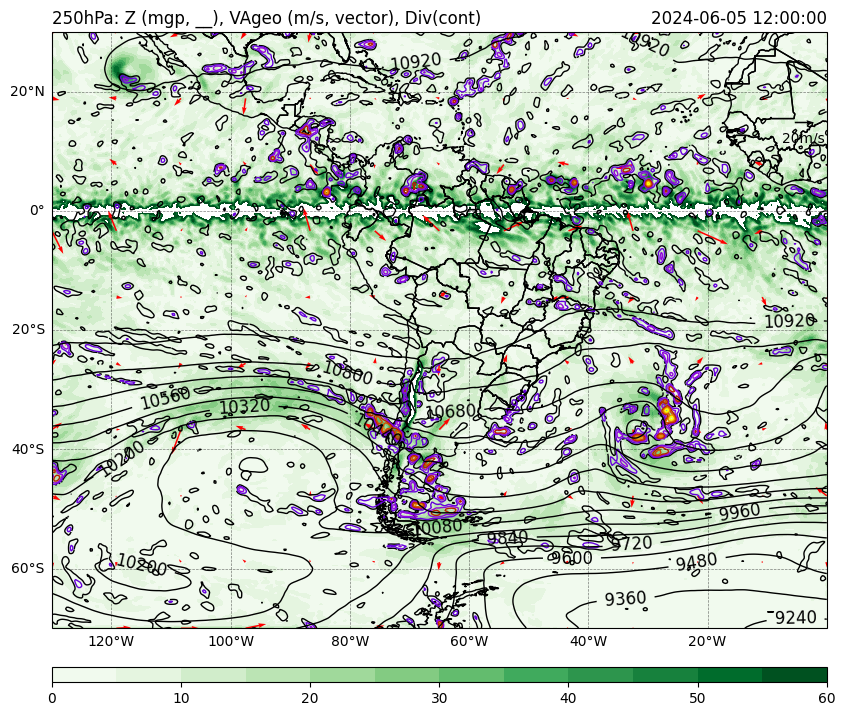

In [8]:
# Create the figure DIV com VAGEO
datacrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=datacrs)

# Add mapping information
# Add state boundaries to plot
states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lakes',scale='50m', facecolor='none')
ax.add_feature(states_provinces, edgecolor='black', linewidth=1)
# Add country borders to plot
country_borders = cfeature.NaturalEarthFeature(category='cultural',
                                               name='admin_0_countries',
                                               scale='50m', facecolor='none')
ax.add_feature(country_borders, edgecolor='black', linewidth=1)
ax.set_extent([lon_o, lon_l, lat_sul, lat_norte], ccrs.PlateCarree())

# ageo speed
clevageo = np.arange(0, 61, 5)
ageo = ax.contourf(lon, lat, speed_ageo, clevageo, cmap='Greens', transform=datacrs)
plt.colorbar(ageo, orientation='horizontal', pad=0.05, aspect=50, extendrect=True)

# Plot the colorfill of divergence, scaled 10^5 every 1 s^1
cs1 = ax.contour(lon, lat, div_nivel*1e5, cmap='gnuplot',linewidths=1.0,linestyles='solid',
                  extend='both', transform=datacrs)
#plt.colorbar(cs1, orientation='horizontal', pad=0.05, aspect=50, extendrect=True)


# Plot Z
#250 hPa
clevz = np.arange(9000., 11000., 120)
#500 hPa
#clevz = np.arange(4320., 6500., 60)
#850 hPa
#clevz = np.arange(0, 8000, 30)
ax.set_extent([lon_o, lon_l, lat_sul, lat_norte], ccrs.PlateCarree())
cs = ax.contour(lon, lat,Z, clevz, colors='black', linewidths=1.0,linestyles='solid',transform=ccrs.PlateCarree())
ax.clabel(cs, fontsize=12, colors='black', inline=1, inline_spacing=8,
          fmt='%i', rightside_up=True, use_clabeltext=True)


uvageo = ax.quiver(lon, lat, ageo_wind_u, ageo_wind_v, color='red',regrid_shape=10,
          width=0.002, scale = 800, transform=ccrs.PlateCarree())
#Draw the wind field, and after the arrow shaft, you have to explain the relationship between the length of the shaft and the wind speed
#Calling quiver can generate reference arrow + label.
ax.quiverkey(uvageo,                     #Incoming quiver handle
             X=0.97, Y = 0.85,       #Determine the location of label, all limited to [0,1]
             U = 20,                    #Reference arrow length means the wind speed is 5m/s.
             angle = 0,            #Reference arrow placement angle. The default is 0, which means horizontal placement
             label='20m/s',        #Arrow's supplement: label's content +
             labelpos='S',          #label is in which direction of the reference arrow; S means south
             color = 'black',labelcolor = 'black', #Arrow color + label color
             )

ax.set_title(f'{nivel}hPa: Z (mgp, __), VAgeo (m/s, vector), Div(cont)', loc='left')
ax.set_title('{}'.format(vtime[0]), loc='right')

# Adding grid lines
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl.top_labels = False
gl.left_labels = True
gl.right_labels = False
gl.xlines = True

# Salva o grafico no disco
#plt.savefig("jato_z_250.png", dpi=600, bbox_inches="tight")

##